# Intro

# Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate, GaussianNoise
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.


# Create toy dataset

One dimensional sine function with noise from two different gaussians with zero mean

In [2]:
N = 4000
N_val = 1000
max_tr = 20
min_val = 0
max_val = 20
sig1 = 0.1
sig2 = 0.3

# Training
X = np.random.uniform(0, max_tr, N)
Y = np.sin(X) + np.random.normal(loc=0, scale=sig1, size=N) + np.random.normal(loc=0, scale=sig2, size=N)

# Validation
X_val = np.random.uniform(min_val, max_val, N_val)
Y_val = np.sin(X_val) + np.random.normal(loc=0, scale=sig1, size=N_val) + np.random.normal(loc=0, scale=sig2, size=N_val)

# Out of distribution samples
X_test1 = np.random.uniform(min_val-10, min_val, int(N_val/2))
X_test2 = np.random.uniform(max_val, max_val+10, int(N_val/2))
X_test = np.concatenate([X_test1, X_test2], axis=0)
Y_test = np.sin(X_test) + np.random.normal(loc=0, scale=sig1, size=N_val) + \
            np.random.normal(loc=0, scale=sig2, size=N_val)

Visualize data

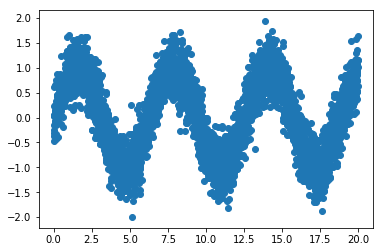

In [3]:
plt.figure()
plt.scatter(X, Y)
plt.show()

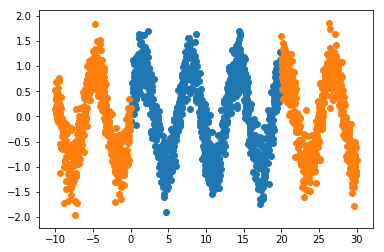

In [4]:
plt.figure()
plt.scatter(X_val, Y_val)
plt.scatter(X_test, Y_test)
plt.show()

# Define model

Model can be used to train a normal dense network or a mixture density network

In [5]:
# Hyperparameters
lr = 0.001
lr_mdn = 0.001
batch_size = 128
epochs = 1000
patience = 20
modes = 1
noise_std = 0.08
mc_samples = 50

In [6]:
def mdn_loss(y_true, y_pred):
    """
    Computes mdn loss
    
    args:
        y_true: labels plus dummy labels for std and weight 
        y_pred: prediction
        
    returns:
        loss
    """
    
    targets = y_true[:, :1]
    means = y_pred[:, :modes]
    std = tf.square(tf.exp(y_pred[:, modes:2*modes]))
    weights = y_pred[:, 2*modes:3*modes]
    
    modes_prob = []
    for i in range(modes):
        diff = tf.subtract(targets, means[:, i:(i+1)])
        m_loss_log = -1*tf.divide(tf.square(diff), 2*std[:, i:(i+1)]) - tf.sqrt(2*np.pi*std[:, i:(i+1)]) + tf.log(weights[:, i:(i+1)])
        modes_prob.append(m_loss_log)
        
    prob = tf.concat(modes_prob, axis=1)
    
    loss = tf.reduce_logsumexp(prob, axis=1)
    loss = tf.reduce_mean(loss, axis=0)
    
    return (-1)*loss

In [7]:
# This layer is equivalent to keras implementation GaussianNoise and does not yiel good estimate of 
# epistemic uncertainty; probably the keras layer GaussianDropout performs better though!
def add_gaussian_noise(inputs, noise_std):
    return inputs + K.random_normal(shape=tf.shape(inputs), mean=0., stddev=noise_std)

# This layer which has to be applied parallel to a layer. The result should then be added to the result of the layer. 
# This is then equivalent to adding gaussian noise with zero mean and standard deviation noise_std to the weights.
def add_gaussian_noise_to_weights(inputs, noise_std):
    return tf.expand_dims(tf.einsum('ij,ij->i', inputs, 
                                    K.random_normal(shape=tf.shape(inputs), mean=0., stddev=noise_std)), 1)

In [9]:
def get_model(mdn=False, gaussian_noise=False, gaussian_noise_end=False):
    
    inp = Input(shape=(1,))
    dense = Dense(100, activation='relu')(inp)
    dense = Dense(100, activation='relu')(dense)
    dense = Dense(100, activation='relu')(dense)
    if gaussian_noise:
        dense = Lambda(lambda x: add_gaussian_noise(x, noise_std))(dense)
    
    if not mdn:
        out = Dense(1)(dense)
        if gaussian_noise_end:
            out2 = Lambda(lambda x: add_gaussian_noise_to_weights(x, noise_std))(dense)
            out = Lambda(lambda x: x[0] + x[1])([out, out2])
    else:
        out_mean = Dense(modes)(dense)
        
        out_std = Dense(modes, name='std')(dense)
        
        out_weights = Dense(modes, activation='softmax')(dense)
        
        out = Concatenate(axis=1)([out_mean, out_std, out_weights])
    
    model = Model(inputs=[inp], outputs=[out])
    
    if not mdn:
        model.compile(Adam(lr=lr), loss='mse')
    else:
        model.compile(Adam(lr=lr_mdn), loss=mdn_loss)
    
    return model

Fit  network with gaussian noise regularization to data

In [10]:
model_gauss = get_model(mdn=False, gaussian_noise=False, gaussian_noise_end=True)

In [11]:
model_gauss.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          200         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          10100       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          10100       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [12]:
model_gauss.fit(
    x = X,
    y = Y,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val, Y_val],
    callbacks = [
        EarlyStopping(patience=patience)
    ]
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 1s 303us/step - loss: 0.7355 - val_loss: 0.6338
Epoch 2/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.6049 - val_loss: 0.6203
Epoch 3/1000
4000/4000 [==============================] - 0s 33us/step - loss: 0.5840 - val_loss: 0.5880
Epoch 4/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.5641 - val_loss: 0.5640
Epoch 5/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.5400 - val_loss: 0.5485
Epoch 6/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.5248 - val_loss: 0.5334
Epoch 7/1000
4000/4000 [==============================] - 0s 32us/step - loss: 0.5139 - val_loss: 0.5254
Epoch 8/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.5117 - val_loss: 0.5261
Epoch 9/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.5063 - val_loss: 0.5239
Epoch 

Epoch 78/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.3828 - val_loss: 0.3977
Epoch 79/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.3799 - val_loss: 0.3907
Epoch 80/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.3741 - val_loss: 0.3996
Epoch 81/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.3693 - val_loss: 0.3847
Epoch 82/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.3622 - val_loss: 0.3831
Epoch 83/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.3669 - val_loss: 0.3743
Epoch 84/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.3595 - val_loss: 0.3830
Epoch 85/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.3651 - val_loss: 0.3744
Epoch 86/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.3547 - val_loss: 0.3699
Epoch 87/1000
4000/4000 [=====================

Epoch 155/1000
4000/4000 [==============================] - 0s 32us/step - loss: 0.2427 - val_loss: 0.2372
Epoch 156/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.2410 - val_loss: 0.2243
Epoch 157/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.2332 - val_loss: 0.2310
Epoch 158/1000
4000/4000 [==============================] - 0s 31us/step - loss: 0.2331 - val_loss: 0.2332
Epoch 159/1000
4000/4000 [==============================] - 0s 30us/step - loss: 0.2320 - val_loss: 0.2269
Epoch 160/1000
4000/4000 [==============================] - 0s 32us/step - loss: 0.2124 - val_loss: 0.2015
Epoch 161/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.2067 - val_loss: 0.2087
Epoch 162/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.1990 - val_loss: 0.1919
Epoch 163/1000
4000/4000 [==============================] - 0s 29us/step - loss: 0.1981 - val_loss: 0.1867
Epoch 164/1000
4000/4000 [===========

Visualize prediction

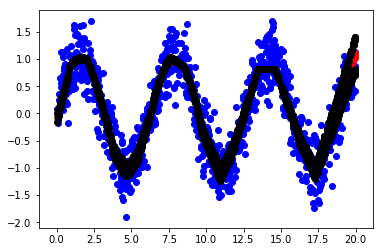

In [13]:
preds_gauss = []
for i in range(mc_samples):
    preds_gauss.append(model_gauss.predict(X_val))
preds_gauss = np.concatenate(preds_gauss, axis=1)

preds_gauss_mean = preds_gauss.mean(axis=1)
preds_gauss_std = preds_gauss.std(axis=1)

plt.figure()
plt.scatter(X_val, Y_val, color='b')
plt.scatter(X_val, preds_gauss_mean, color='r')
plt.scatter(X_val, preds_gauss_mean + preds_gauss_std, color='k')
plt.scatter(X_val, preds_gauss_mean - preds_gauss_std, color='k')
plt.show()

In [14]:
print('Mean std: ')
print(preds_gauss_std.mean())

Mean std: 
0.0659073


# Visualize uncertainty estimate

Variance depending on prediction error for network with gaussian noise regularization

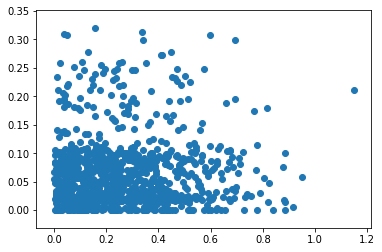

In [15]:
plt.figure()
plt.scatter(np.abs(preds_gauss_mean - Y_val), preds_gauss_std)
plt.show()

# Run on out of distribution samples X_test

Gaussian noise network

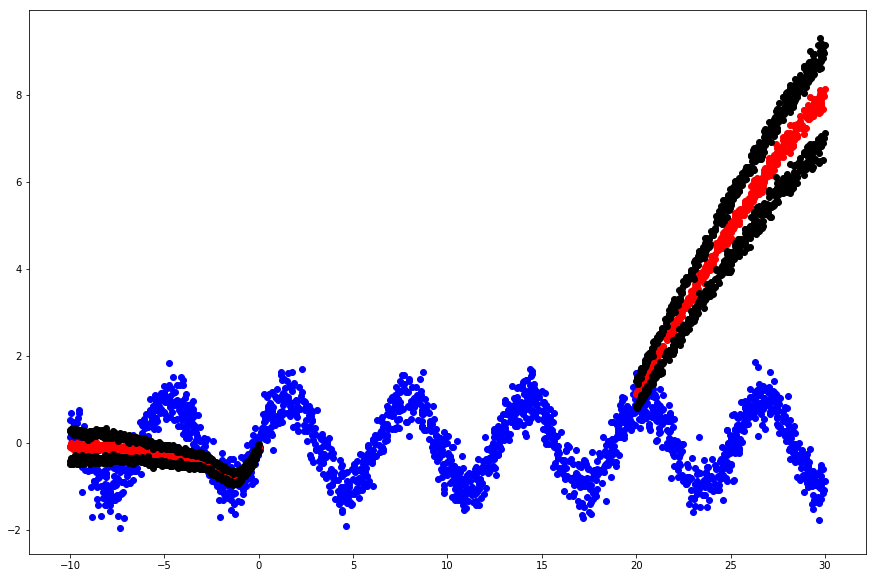

In [16]:
preds_gauss = []
for i in range(mc_samples):
    preds_gauss.append(model_gauss.predict(X_test))
preds_gauss = np.concatenate(preds_gauss, axis=1)

preds_gauss_mean = preds_gauss.mean(axis=1)
preds_gauss_std = preds_gauss.std(axis=1)

plt.figure(figsize=(15,10))
plt.scatter(X_val, Y_val, color='b')
plt.scatter(X_test, Y_test, color='b')
plt.scatter(X_test, preds_gauss_mean, color='r')
plt.scatter(X_test, preds_gauss_mean + preds_gauss_std, color='k')
plt.scatter(X_test, preds_gauss_mean - preds_gauss_std, color='k')
plt.show()

In [17]:
print('Mean sigma:')
print(preds_gauss_std.mean())

Mean sigma:
0.44288325


In [18]:
model_gauss.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          200         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          10100       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          10100       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [19]:
out = model_gauss.layers[-3].output
last_activation = model_gauss.layers[-4].output

In [20]:
model_without_gauss = Model([model_gauss.input], [out])
model_without_gauss_last_activation = Model([model_gauss.input], [last_activation])

Now we compute the uncertainty of the model via error propagation instead of sampling. Since our final output is 1-dimensional the last operation with above noise definition (add_gaussian_noise_to_weights) is a sum of two scalar products:

$$output = \vec{a}^T \vec{w} + \vec{a}^T \vec{\sigma}$$

with a the second last layer activation and w the last layer weights. Sigma is a vector of Gaussian noise with 0 mean and above standard deviation (noise_std). To estimate the error $\Delta output$ induced by this Gaussian layer we propagate the "errors" of the weights (~standard deviation of weights). Since the "drawn" weights are statstically independent by construction the approximated output error is given by:

$$\Delta output \approx \sqrt{\sum_i^{n}\left(\frac{\partial output}{\partial \sigma_i}\Delta \sigma_i\right)^2} \approx \sqrt{\sum_i^{n}\left(\frac{\partial output}{\partial \sigma_i}noisestd\right)^2} = noisestd * |a|_2$$

with n dimenstionality of last hidden layer, noisestd the above with standard deviation for regularizing Gaussian noise and $|a|_2$ the l2-norm of the last hidden layer activation. 

This yields the following uncertainty for samples inside the training distribution:

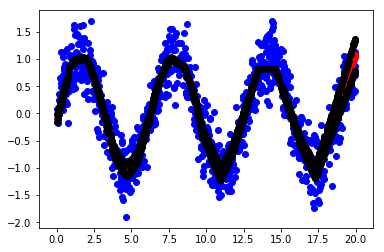

In [38]:
preds = model_without_gauss.predict(X_val)

last_activations = model_without_gauss_last_activation.predict(X_val)
la_squared = last_activations**2
std = np.sqrt(la_squared.sum(axis=1)) * noise_std

plt.figure()
plt.scatter(X_val, Y_val, color='b')
plt.scatter(X_val, preds[:, 0], color='r')
plt.scatter(X_val, preds[:, 0] + std, color='k')
plt.scatter(X_val, preds[:, 0] - std, color='k')
plt.show()

In [39]:
print('Mean std:')
print(std.mean())

Mean std:
0.067025006


Mean error:

In [41]:
error = np.mean(np.abs(preds[:, 0] - Y_val))

print('Mean error: ' + str(error))

Mean error: 0.2612704508770752


Uncertainty on out of training distribution samples

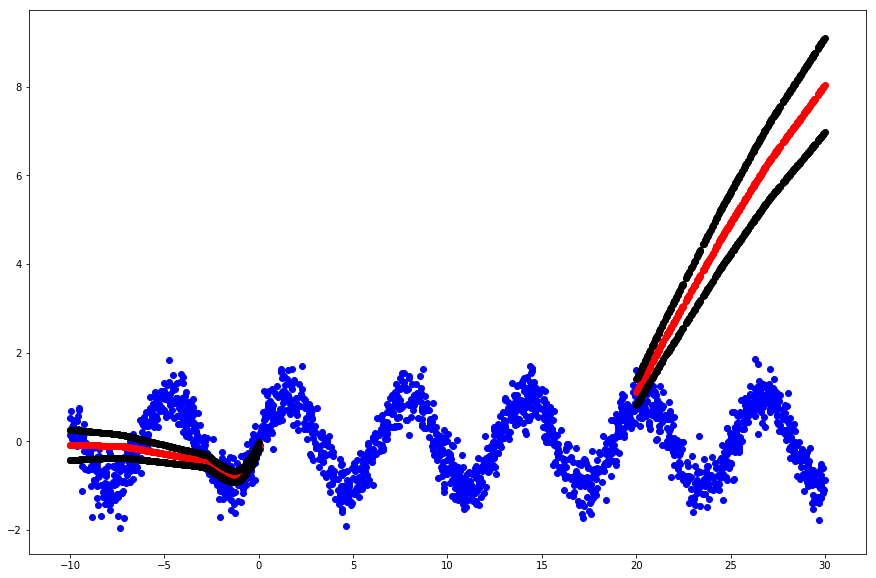

In [35]:
preds = model_without_gauss.predict(X_test)

last_activations = model_without_gauss_last_activation.predict(X_test)
la_squared = last_activations**2
std = np.sqrt(la_squared.sum(axis=1)) * noise_std

plt.figure(figsize=(15,10))
plt.scatter(X_val, Y_val, color='b')
plt.scatter(X_test, Y_test, color='b')
plt.scatter(X_test, preds[:, 0], color='r')
plt.scatter(X_test, preds[:, 0] + std, color='k')
plt.scatter(X_test, preds[:, 0] - std, color='k')
plt.show()

In [36]:
print('Mean std:')
print(std.mean())

Mean std:
0.45157367
